<a href="https://www.kaggle.com/code/debbiechu/regression?scriptVersionId=174770951" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [22]:
train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')

### EDA

In [23]:
train.isnull().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64

<Axes: xlabel='Sex', ylabel='count'>

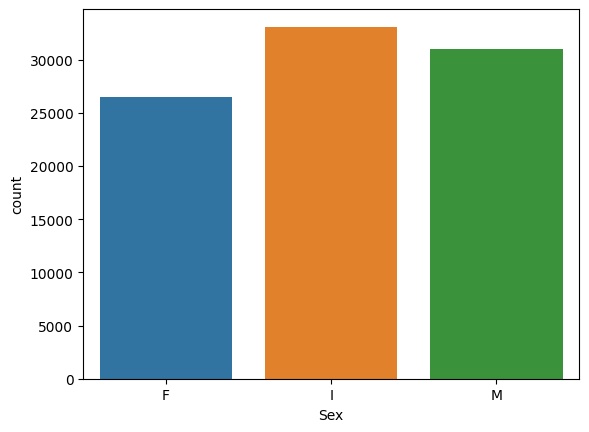

In [24]:
sns.countplot(x='Sex', data=train)

<Axes: xlabel='Rings', ylabel='count'>

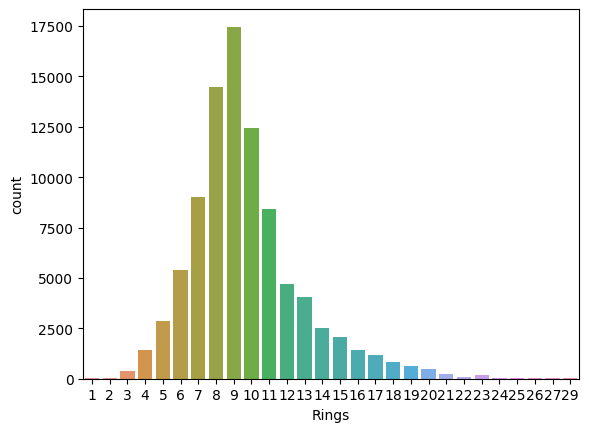

In [25]:
sns.countplot(x='Rings', data=train)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

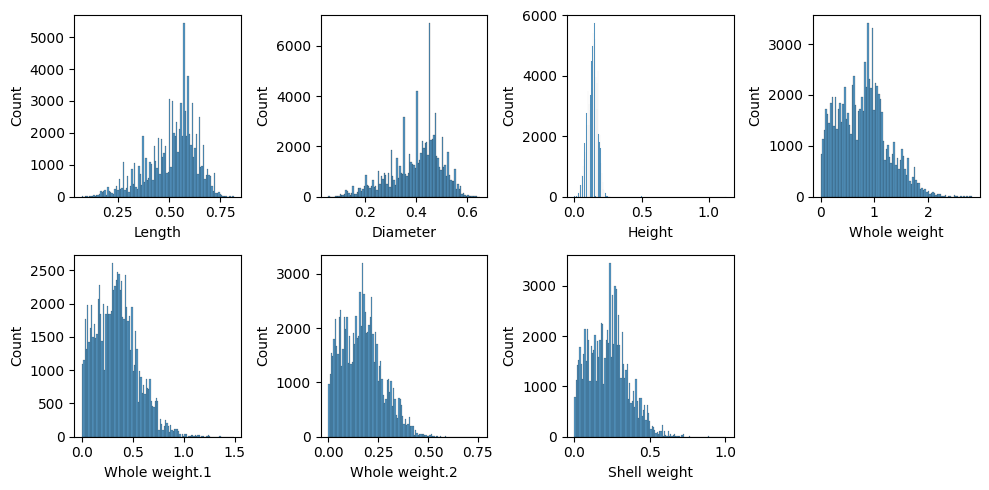

In [26]:
# distribution of numerical variables
cols = train.drop(['id','Rings','Sex'],axis=1).columns

plt.figure(figsize=(10, 5))
for i, col in enumerate(cols):
    plt.subplot(2, 4, i + 1)
    sns.histplot(x=col, data=train)
    plt.tight_layout()
plt.show()

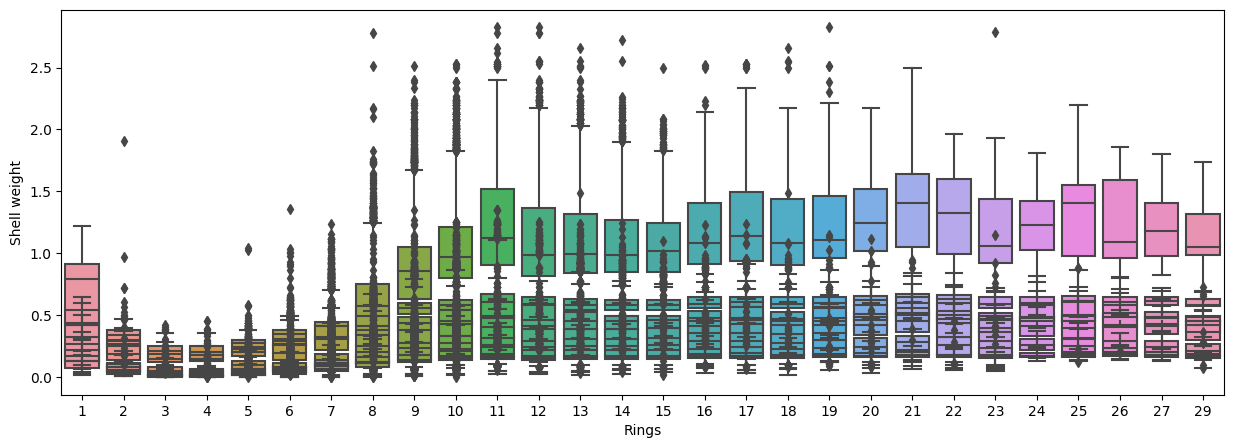

In [27]:
# distribution of numerical variables across target 'Rings'
plt.figure(figsize=(15, 5))
for i, col in enumerate(cols):
    sns.boxplot(x='Rings', y=col, data=train)
plt.show()

In [28]:
# is there a statistically significant difference across "Rings" groups?

from scipy.stats import kruskal

results = {}

for col in cols:
    # split data by Rings categories
    groups = [group[col] for name, group in train.groupby('Rings')]
    test_stat, p_value = kruskal(*groups)
    results[col] = {'Test Statistic': test_stat, 'p-value': p_value}

results

{'Length': {'Test Statistic': 52656.86135684183, 'p-value': 0.0},
 'Diameter': {'Test Statistic': 53570.232238430326, 'p-value': 0.0},
 'Height': {'Test Statistic': 55771.867372093395, 'p-value': 0.0},
 'Whole weight': {'Test Statistic': 54719.68559770384, 'p-value': 0.0},
 'Whole weight.1': {'Test Statistic': 49309.22634384786, 'p-value': 0.0},
 'Whole weight.2': {'Test Statistic': 53620.67780874843, 'p-value': 0.0},
 'Shell weight': {'Test Statistic': 59544.89707955147, 'p-value': 0.0}}

In [29]:
train['Sex_coded'], _ = pd.factorize(train['Sex'])
test['Sex_coded'], _ = pd.factorize(test['Sex'])

train.drop('Sex', axis=1,inplace=True)
test.drop('Sex', axis=1,inplace=True)

In [30]:
# train test split

from sklearn.model_selection import train_test_split

X = train.drop(['id','Rings'], axis=1)
y = train['Rings']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test.drop(['id'], axis=1)

# scale 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [31]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error

rf = RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300, random_state=42)
rf.fit(X_train_scaled, y_train)
pred_rf=rf.predict(X_val_scaled)

xgb = XGBRegressor(colsample_bytree=0.7, learning_rate=0.1, max_depth= 5, n_estimators= 300, subsample= 1.0, random_state=42)
xgb.fit(X_train_scaled, y_train)
pred_xgb=xgb.predict(X_val_scaled)

average_preds = (pred_rf + pred_xgb) / 2

def calculate_rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

ensemble_error = calculate_rmsle(y_val, average_preds)
print("Ensemble RMSE:", ensemble_error)

Ensemble RMSE: 0.15193492003901712


In [32]:
sample_sub = pd.read_csv('/kaggle/input/playground-series-s4e4/sample_submission.csv')
sample_sub.head()

,id,Rings
0,90615,10
1,90616,10
2,90617,10
3,90618,10
4,90619,10


In [33]:
# test set
pred_rf_t=rf.predict(X_test_scaled)
pred_xgb_t=xgb.predict(X_test_scaled)
average_preds = (pred_rf_t + pred_xgb_t) / 2

submission = pd.DataFrame(average_preds, columns=['Rings'])
submission['id'] = test['id']
submission.head()

,Rings,id
0,9.664724,90615
1,9.760275,90616
2,10.344144,90617
3,10.565258,90618
4,7.553562,90619


In [34]:
submission.to_csv('submission.csv', index=False)